# FINAL Part 2: Sourcing stock data from commercial API

### Load Packages

note: use root kernel

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
from pandas import date_range
import dill
from pprint import pprint
import requests
import ratelimit
from ratelimit import limits, sleep_and_retry
import re
import requests
import intrinio
import intrinio_sdk
from intrinio_sdk.rest import ApiException
import datetime
import time
from datetime import timedelta
import calendar
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [44]:
#!pip install missingno

## Pulling pricing data from Intrinio

In [46]:
f = open('myKey.pckl', 'rb')
myKey= dill.load(f)
f.close()

intrinio_sdk.ApiClient().configuration.api_key['api_key'] = "OjdhZTAyYzZhZmQxMmU3OTU5YjA1NWY5MzhmZDk1Y2E0" #myKey
security_api = intrinio_sdk.SecurityApi()

In [47]:
from tqdm import tqdm
from itertools import islice
prices = []
not_found = []
asset_volume_dict={}
asset_marketcap_dict = {}
asset_price_dict= {}

In [97]:
#if exceptions appear, rerun the this cell and the next cell:
#tickerList = not_found

# tickerList = ['ZAHLY']

# f = open('tickerList.pckl', 'rb')
# tickerList = dill.load(f)
# f.close()

# f = open('./data/prices.pckl', 'rb')
# prices = dill.load(f)
# f.close()

# f = open('./data/not_found.pckl', 'rb')
# not_found = dill.load(f)
# f.close()

# f = open('./data/asset_volume_dict.pckl', 'rb')
# asset_volume_dict = dill.load(f)
# f.close()

# f = open('./data/asset_marketcap_dict.pckl', 'rb')
# asset_marketcap_dict = dill.load(f)
# f.close()

# f = open('./data/asset_price_dict.pckl', 'rb')
# asset_price_dict = dill.load(f)
# f.close()

#len(prices)

In [98]:
for identifier in tqdm(tickerList):
    try:
        time.sleep(2)
        api_response = security_api.get_security_stock_prices(identifier,next_page = '')
        datetime = [v.date for v in api_response._stock_prices]
        closing = [v.close for v in api_response._stock_prices]
        adj_close = [v.adj_close for v in api_response._stock_prices]
        adj_high = [v.adj_high for v in api_response._stock_prices]
        adj_low = [v.adj_low for v in api_response._stock_prices]
        adj_open = [v.adj_open for v in api_response._stock_prices]
        adj_volume = [v.adj_volume for v in api_response._stock_prices]
        close = [v.close for v in api_response._stock_prices]
        low = [v.low for v in api_response._stock_prices]
        frequency = [v.frequency for v in api_response._stock_prices]
        high = [v.high for v in api_response._stock_prices]
        intraperiod = [v.intraperiod for v in api_response._stock_prices]
        open_ = [v.open for v in api_response._stock_prices]
        volume = [v.volume for v in api_response._stock_prices]
        

        while api_response.next_page is not None:
            try:
                print(api_response.next_page)
                time.sleep(2)
                api_response = security_api.get_security_stock_prices(identifier, next_page=api_response.next_page)           
                adj_close.extend([v.adj_close for v in api_response._stock_prices])
                adj_high.extend([v.adj_high for v in api_response._stock_prices])
                adj_low.extend([v.adj_low for v in api_response._stock_prices])
                adj_open.extend([v.adj_open for v in api_response._stock_prices])
                adj_volume.extend([v.adj_volume for v in api_response._stock_prices])
                close.extend([v.close for v in api_response._stock_prices])
                datetime.extend([v.date for v in api_response._stock_prices])
                low.extend([v.low for v in api_response._stock_prices])
                frequency.extend([v.frequency for v in api_response._stock_prices])
                high.extend([v.high for v in api_response._stock_prices])
                intraperiod.extend([v.intraperiod for v in api_response._stock_prices])
                open_.extend([v.open for v in api_response._stock_prices])
                volume.extend([v.volume for v in api_response._stock_prices])
                
            except:
                pass

        df_pricebyidentifier = pd.DataFrame.from_records(\
                                zip(datetime,open_,close,high,low,volume,adj_close,adj_high,adj_low,\
                                adj_open,adj_volume,frequency,intraperiod),\
                                                         columns=['datetime','open','close','high','low','volume', \
                                                                  'adj_close','adj_high','adj_low',\
                                                                  'adj_open','adj_volume','frequency','intraperiod'])
        
        df_pricebyidentifier = df_pricebyidentifier.sort_index(ascending = False)
            
        df_pricebyidentifier['marketcap'] = df_pricebyidentifier.apply(lambda row: \
                                                                        (row['adj_close']*row['adj_volume']),\
                                                                        axis=1)

        
        asset_volume_dict[identifier] = df_pricebyidentifier[['datetime', 'adj_volume']]
        
        asset_marketcap_dict[identifier] = df_pricebyidentifier[['datetime', 'marketcap']]
                
        asset_price_dict[identifier] = df_pricebyidentifier[['datetime', 'adj_close']]
        
        index_ = pd.DataFrame(pd.to_datetime(df_pricebyidentifier.datetime,errors='coerce'))
        index_['asset']= identifier
        index = pd.MultiIndex.from_frame(index_)
        prices.append(df_pricebyidentifier.set_index(index).drop('datetime',axis=1))
        
    except ApiException as e:
        not_found.append(identifier)
        print("Exception when calling SecurityApi->get_security_stock_prices: %s\n" % e)
        pass
        




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Exception when calling SecurityApi->get_security_stock_prices: (404)
Reason: Not Found
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 09 Jun 2019 00:33:15 GMT', 'Content-Type': 'application/json', 'Content-Length': '114', 'Connection': 'keep-alive', 'Vary': 'Origin,Accept-Encoding'})
HTTP response body: {"error":"Security not found","message":"An error occured. Please contact success@intrinio.com with the details."}







100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/it]

In [108]:
price = pd.concat(prices,axis='index')

In [103]:
price.shape

(215489, 13)

In [111]:
price.groupby("asset").head(1)

,,open,close,high,low,volume,adj_close,adj_high,adj_low,adj_open,adj_volume,frequency,intraperiod,marketcap
datetime,asset,,,,,,,,,,,,,
2018-09-12,YI,16.750,13.80,16.8300,11.575,1302171.0,13.800000,16.830000,11.575000,16.750000,1.302171e+06,daily,False,1.796996e+07
2011-04-21,VNET,20.260,18.80,22.3300,18.340,18178500.0,18.800000,22.330000,18.340000,20.260000,1.817850e+07,daily,False,3.417558e+08
2018-12-14,QFIN,16.810,16.50,17.5291,16.500,597942.0,16.500000,17.529100,16.500000,16.810000,5.979420e+05,daily,False,9.866043e+06
2013-11-22,WBAI,20.000,20.01,22.0400,18.140,6900300.0,20.010000,22.040000,18.140000,20.000000,6.900300e+06,daily,False,1.380750e+08
2004-09-29,JOBS,22.050,21.15,22.9000,18.610,6068400.0,10.575000,11.450000,9.305000,11.025000,1.213680e+07,daily,False,1.283467e+08
2013-10-31,WUBA,21.200,24.12,27.0000,21.000,20628500.0,24.120000,27.000000,21.000000,21.200000,2.062850e+07,daily,False,4.975594e+08
2007-05-03,ATV,19.900,21.50,22.7150,18.500,0.0,57.808542,61.075397,49.742234,53.506511,0.000000e+00,daily,False,0.000000e+00
2007-11-07,AMCN,19.500,20.90,22.7100,19.200,11907600.0,104.500000,113.550000,96.000000,97.500000,2.381520e+06,daily,False,2.488688e+08
2014-09-19,BABA,92.700,93.89,99.7000,89.950,271879400.0,93.890000,99.700000,89.950000,92.700000,2.718794e+08,daily,False,2.552676e+10


In [109]:
price.groupby("asset").tail(1)

open       close        high       low      volume  \
datetime   asset                                                            
2019-06-07 YI       7.35000    7.160000    7.350000    7.1600      6296.0   
           VNET     7.26000    7.110000    7.364000    6.9900    508778.0   
           QFIN    14.39000   13.580000   14.820000   13.2900    116434.0   
           WBAI     8.55000    8.430000    8.680000    8.4300     35540.0   
           JOBS    69.63000   71.080000   71.535000   69.0500    201787.0   
           WUBA    56.50000   57.630000   58.000000   56.2500    349451.0   
           ATV     23.50000   24.280000   24.673800   23.5000     13295.0   
           AMCN     1.71000    1.680000    1.891400    1.6600     18928.0   
           BABA   152.95000  154.230000  155.690000  152.2135  17814632.0   
           ACH      8.81000    8.970000    8.970000    8.8000     17085.0   
           ATAI     2.00000    1.990000    2.053500    1.9400     30871.0   
           JG       6.27000    5.620000    6.400000    5.1200    327036.0   
           ATHM    88.54000   91.780000   92.685000   88.5400    577632.0   
           BIDU   109.10000  109.810000  110.649900  109.0300   2581378.0   
           BZUN    40.06000   42.040000   42.753600   40.0400    956732.0   
           BILI    14.15000   14.800000   15.100000   14.1000   5001950.0   
           BEDU     9.45000    9.350000    9.477100    9.2800     69198.0   
           CANG     5.03000    5.030000    5.030000    5.0300       115.0   
           CYOU     9.88000   10.440000   10.450000    9.8700    259992.0   
           CMCM     3.96000    3.970000    4.070000    3.8800    439224.0   
           DL       5.52000    5.510000    5.700000    5.5100     10892.0   
           CEA     27.20000   27.570000   27.570000   27.2000     10251.0   
           JRJC     0.81300    0.808000    0.813000    0.7810      7646.0   
           LFC     11.34000   11.380000   11.540000   11.3400    355834.0   
           HTHT    30.40000   31.260000   31.520000   30.2050    967788.0   
           CHL     45.10000   45.120000   45.340000   44.9700    370944.0   
           CEO    159.21000  160.340000  161.490000  159.2100     58535.0   
           BORN     0.70000    0.450000    0.702152    0.4000    416310.0   
           COE      6.46000    6.510000    6.530000    6.0773      4710.0   
           SNP     65.81000   66.180000   66.660000   65.8100    141229.0   
...                     ...         ...         ...       ...         ...   
           RENN     1.30000    1.310000    1.339800    1.2900     75001.0   
           REDU     9.11000    9.500000    9.580000    9.0600    189584.0   
           RYB      6.54000    6.630000    6.770000    6.4100     36929.0   
           SECO     7.41000    7.600000    7.800000    7.2900     55210.0   
           SHI     42.77000   42.800000   43.070000   42.5500     21923.0   
           SKYS     0.55000    0.539109    0.550000    0.5300     44230.0   
           SOGO     3.91000    3.910000    4.000000    3.8500    628509.0   
           SOHU    13.53000   13.810000   13.890000   13.3800    209888.0   
           TAL     34.61000   35.260000   35.700000   34.4000   1864369.0   
           TEDU     3.06530    3.240000    3.410000    3.0653     28701.0   
           TME     13.34000   13.610000   13.930000   13.2000   8175543.0   
           NCTY     1.15000    1.170000    1.188300    1.1500     53799.0   
           TC       3.01000    3.200000    3.230000    3.0100    101257.0   
           TOUR     3.03000    3.050000    3.130000    2.9600     31559.0   
           VIPS     7.08000    7.230000    7.390000    7.0500   5043455.0   
           WB      41.75000   42.400000   42.820000   41.6400   2047663.0   
           XYF      3.86380    3.950000    3.970000    3.8600     13854.0   
           XIN      4.40000    4.460000    4.480000    4.4000    101864.0   
           XNET     2.15000    2.190000    2.220000    1.9880    461072.0   
           YIN     

In [118]:
with open('./data/price.pckl', 'wb') as handle:
    dill.dump(price, handle)

with open('./data/prices.pckl', 'wb') as handle:
    dill.dump(prices, handle)

with open('./data/not_found.pckl', 'wb') as handle:
    dill.dump(not_found, handle)


with open('./data/asset_volume_dict.pckl', 'wb') as handle:
    dill.dump(asset_volume_dict, handle)
    

with open('./data/asset_marketcap_dict.pckl', 'wb') as handle:
    dill.dump(asset_marketcap_dict, handle)


with open('./data/asset_price_dict.pckl', 'wb') as handle:
    dill.dump(asset_price_dict, handle)

In [ ]:
price.to_csv('./data/price.csv',header=True)

In [115]:
price.head(5)

,,open,close,high,low,volume,adj_close,adj_high,adj_low,adj_open,adj_volume,frequency,intraperiod,marketcap
datetime,asset,,,,,,,,,,,,,
2018-09-12,YI,16.75,13.80,16.830,11.575,1302171.0,13.80,16.830,11.575,16.75,1302171.0,daily,False,17969959.80
2018-09-13,YI,13.90,14.00,14.220,13.000,683958.0,14.00,14.220,13.000,13.90,683958.0,daily,False,9575412.00
2018-09-14,YI,14.60,13.99,14.730,13.051,773447.0,13.99,14.730,13.051,14.60,773447.0,daily,False,10820523.53
2018-09-17,YI,13.61,13.72,13.919,13.250,195747.0,13.72,13.919,13.250,13.61,195747.0,daily,False,2685648.84
2018-09-18,YI,13.85,13.06,13.850,12.700,259155.0,13.06,13.850,12.700,13.85,259155.0,daily,False,3384564.30


In [113]:
asset_volume_dict

{'YI':        datetime  adj_volume
 184  2018-09-12   1302171.0
 183  2018-09-13    683958.0
 182  2018-09-14    773447.0
 181  2018-09-17    195747.0
 180  2018-09-18    259155.0
 179  2018-09-19     96016.0
 178  2018-09-20     55989.0
 177  2018-09-21    297027.0
 176  2018-09-24     76168.0
 175  2018-09-25     91532.0
 174  2018-09-26     15203.0
 173  2018-09-27     15305.0
 172  2018-09-28     20370.0
 171  2018-10-01     37720.0
 170  2018-10-02     45656.0
 169  2018-10-03     62029.0
 168  2018-10-04    153924.0
 167  2018-10-05    119745.0
 166  2018-10-08     78433.0
 165  2018-10-09     77143.0
 164  2018-10-10     20279.0
 163  2018-10-11     32215.0
 162  2018-10-12     23799.0
 161  2018-10-15     48125.0
 160  2018-10-16     41059.0
 159  2018-10-17      8499.0
 158  2018-10-18      8805.0
 157  2018-10-19     38553.0
 156  2018-10-22     46117.0
 155  2018-10-23     16520.0
 ..          ...         ...
 29   2019-04-26     11889.0
 28   2019-04-29     15185.0
 27   20

In [116]:
asset_marketcap_dict

{'YI':        datetime     marketcap
 184  2018-09-12  1.796996e+07
 183  2018-09-13  9.575412e+06
 182  2018-09-14  1.082052e+07
 181  2018-09-17  2.685649e+06
 180  2018-09-18  3.384564e+06
 179  2018-09-19  1.326941e+06
 178  2018-09-20  7.564114e+05
 177  2018-09-21  4.586097e+06
 176  2018-09-24  1.128048e+06
 175  2018-09-25  1.287855e+06
 174  2018-09-26  2.174029e+05
 173  2018-09-27  2.112090e+05
 172  2018-09-28  2.754024e+05
 171  2018-10-01  5.046936e+05
 170  2018-10-02  5.364580e+05
 169  2018-10-03  7.049596e+05
 168  2018-10-04  1.662379e+06
 167  2018-10-05  1.451309e+06
 166  2018-10-08  9.129601e+05
 165  2018-10-09  8.601445e+05
 164  2018-10-10  2.131323e+05
 163  2018-10-11  3.173178e+05
 162  2018-10-12  2.225206e+05
 161  2018-10-15  4.807688e+05
 160  2018-10-16  4.368678e+05
 159  2018-10-17  9.136425e+04
 158  2018-10-18  8.981100e+04
 157  2018-10-19  3.427362e+05
 156  2018-10-22  3.698583e+05
 155  2018-10-23  1.329860e+05
 ..          ...           ...
 2

In [117]:
asset_price_dict

{'YI':        datetime  adj_close
 184  2018-09-12    13.8000
 183  2018-09-13    14.0000
 182  2018-09-14    13.9900
 181  2018-09-17    13.7200
 180  2018-09-18    13.0600
 179  2018-09-19    13.8200
 178  2018-09-20    13.5100
 177  2018-09-21    15.4400
 176  2018-09-24    14.8100
 175  2018-09-25    14.0700
 174  2018-09-26    14.3000
 173  2018-09-27    13.8000
 172  2018-09-28    13.5200
 171  2018-10-01    13.3800
 170  2018-10-02    11.7500
 169  2018-10-03    11.3650
 168  2018-10-04    10.8000
 167  2018-10-05    12.1200
 166  2018-10-08    11.6400
 165  2018-10-09    11.1500
 164  2018-10-10    10.5100
 163  2018-10-11     9.8500
 162  2018-10-12     9.3500
 161  2018-10-15     9.9900
 160  2018-10-16    10.6400
 159  2018-10-17    10.7500
 158  2018-10-18    10.2000
 157  2018-10-19     8.8900
 156  2018-10-22     8.0200
 155  2018-10-23     8.0500
 ..          ...        ...
 29   2019-04-26     8.8000
 28   2019-04-29     8.6500
 27   2019-04-30     8.1500
 26   2019-05-

In [127]:
# OHLC_adj = price[['adj_close','adj_high','adj_low','adj_open','adj_volume', 'marketcap']]
# OHLC = price[['close','high','low','open_','volume', 'marketcap']]
# OHLC['dividend']=0
# OHLC['split']=1

# with open('./data/OHLC_adj.pckl', 'wb') as handle:
#     dill.dump(OHLC_adj, handle)
    
# with open('./data/OHLC.pckl', 'wb') as handle:
#     dill.dump(OHLC, handle)

# To obtain a daily returns dictionary for backtesting

In [148]:
daily_return_df = price.copy()

daily_return_series = daily_return_df.groupby(level='asset')['adj_close'].pct_change().fillna(method='ffill').fillna(method='bfill')

daily_return_df = pd.DataFrame(daily_return_series)

price['daily_return'] = daily_return_series

In [157]:
price.head()

,,open,close,high,low,volume,adj_close,adj_high,adj_low,adj_open,adj_volume,frequency,intraperiod,marketcap,daily_return
datetime,asset,,,,,,,,,,,,,,
2018-09-12,YI,16.75,13.80,16.830,11.575,1302171.0,13.80,16.830,11.575,16.75,1302171.0,daily,False,17969959.80,0.014493
2018-09-13,YI,13.90,14.00,14.220,13.000,683958.0,14.00,14.220,13.000,13.90,683958.0,daily,False,9575412.00,0.014493
2018-09-14,YI,14.60,13.99,14.730,13.051,773447.0,13.99,14.730,13.051,14.60,773447.0,daily,False,10820523.53,-0.000714
2018-09-17,YI,13.61,13.72,13.919,13.250,195747.0,13.72,13.919,13.250,13.61,195747.0,daily,False,2685648.84,-0.019299
2018-09-18,YI,13.85,13.06,13.850,12.700,259155.0,13.06,13.850,12.700,13.85,259155.0,daily,False,3384564.30,-0.048105


In [158]:
with open('./data/price.pckl', 'wb') as handle:
    dill.dump(price, handle)

In [160]:
#Prepare a backup copy of the price dataframe to this stage as we use the price.pckl for processing
with open('./data/raw_price_fromAPI.pckl', 'wb') as handle:
    dill.dump(price, handle)

# issues start from here. Trying to write the daily_return_df dataframe to dictionary

In [164]:
# daily_returns is a dictionary with dates as keys, this is the format we want for the next part
daily_return={}
daily_return = {col : daily_return_df[col].reset_index() for col in daily_return_df.columns}

In [166]:
daily_return

{'adj_close':          datetime  asset  adj_close
 0      2018-09-12     YI   0.014493
 1      2018-09-13     YI   0.014493
 2      2018-09-14     YI  -0.000714
 3      2018-09-17     YI  -0.019299
 4      2018-09-18     YI  -0.048105
 5      2018-09-19     YI   0.058193
 6      2018-09-20     YI  -0.022431
 7      2018-09-21     YI   0.142857
 8      2018-09-24     YI  -0.040803
 9      2018-09-25     YI  -0.049966
 10     2018-09-26     YI   0.016347
 11     2018-09-27     YI  -0.034965
 12     2018-09-28     YI  -0.020290
 13     2018-10-01     YI  -0.010355
 14     2018-10-02     YI  -0.121824
 15     2018-10-03     YI  -0.032766
 16     2018-10-04     YI  -0.049714
 17     2018-10-05     YI   0.122222
 18     2018-10-08     YI  -0.039604
 19     2018-10-09     YI  -0.042096
 20     2018-10-10     YI  -0.057399
 21     2018-10-11     YI  -0.062797
 22     2018-10-12     YI  -0.050761
 23     2018-10-15     YI   0.068449
 24     2018-10-16     YI   0.065065
 25     2018-10-17     YI

In [168]:
with open('./data/daily_return.pkl', 'wb') as file: 
    dill.dump(daily_return, file)

# Check completeness of price data

In [ ]:
price=pd.read_csv('./data/price.csv')
# OHLC=pd.read_csv('./data/OHLC.csv')
# OHLC_adj=pd.read_csv('./data/OHLC_adj.csv')

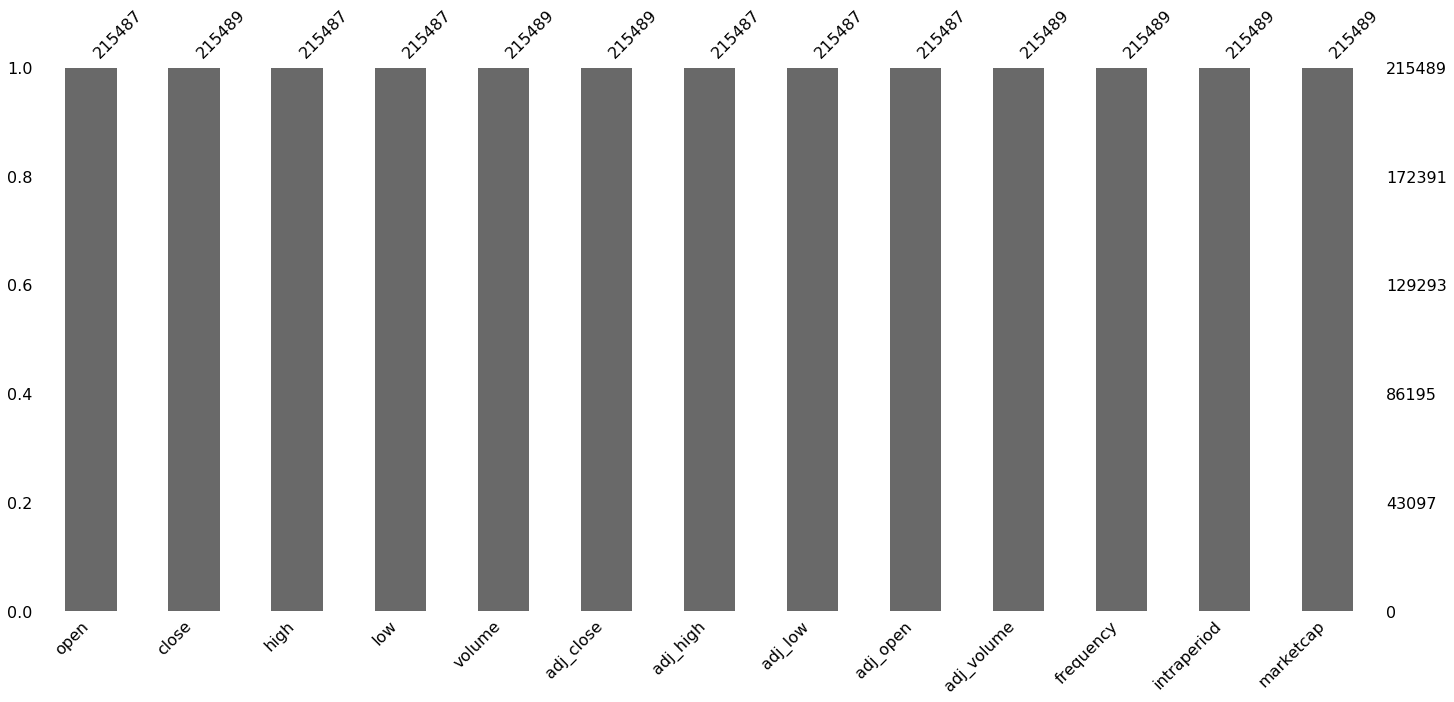

In [119]:
msno.bar(price)

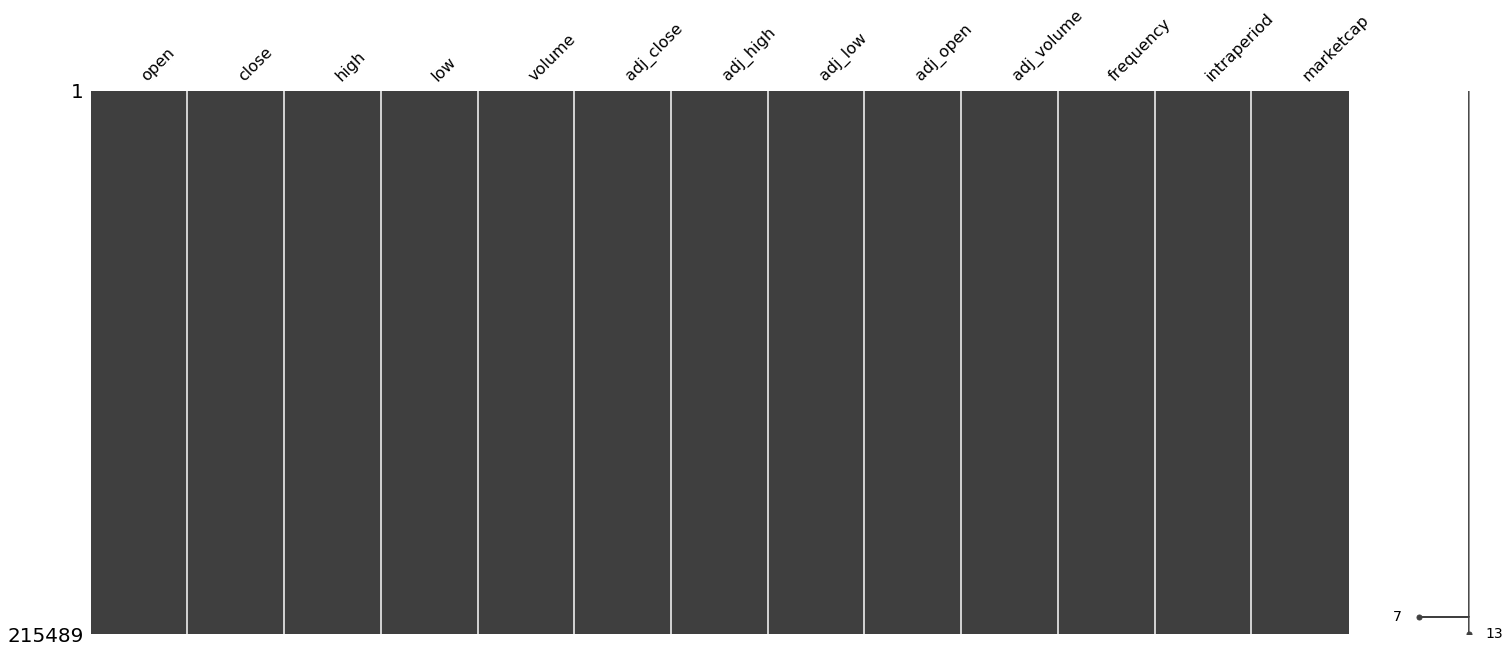

In [120]:
msno.matrix(price)

<Figure size 432x288 with 0 Axes>

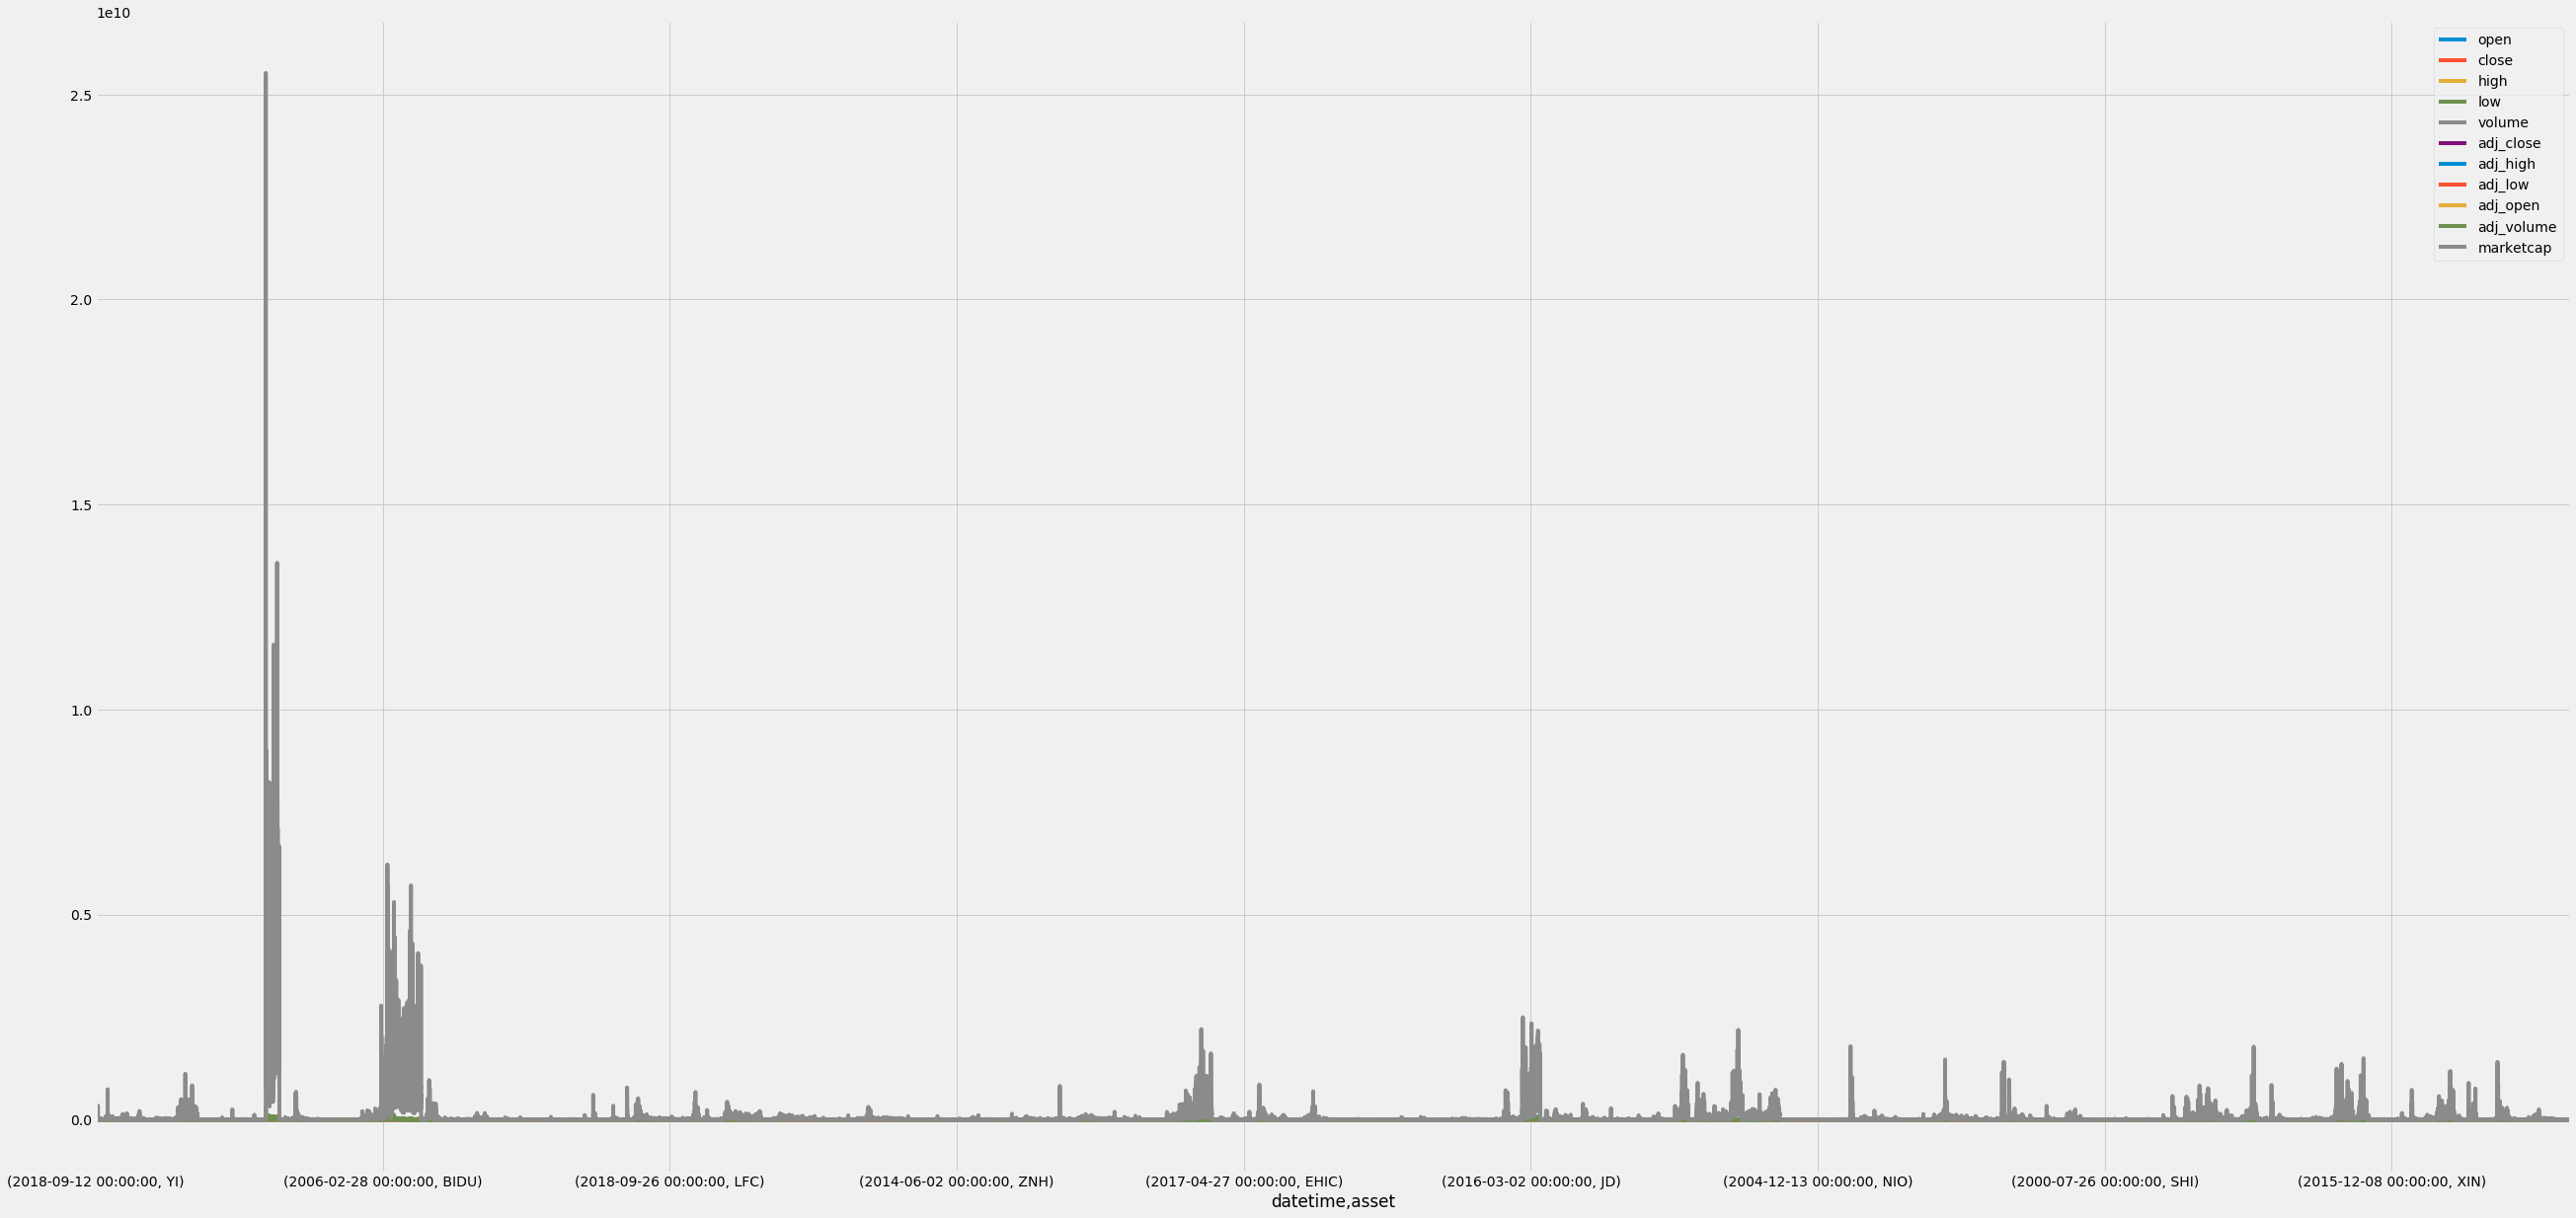

In [121]:
plt.tight_layout()
plt.style.use('fivethirtyeight')
price.plot(figsize=(40,20))

# Optional: Transform adjusted closing price data into series if using Alphalens

In [5]:
f = open('./data/price.pckl', 'rb')
price= dill.load(f)
f.close()

price = pd.DataFrame(price.adj_close).adj_close
price.head()

datetime    asset
2018-09-12  YI       13.80
2018-09-13  YI       14.00
2018-09-14  YI       13.99
2018-09-17  YI       13.72
2018-09-18  YI       13.06
Name: adj_close, dtype: float64

In [6]:
price = price.reset_index()

In [7]:
price['datetime'] = pd.DatetimeIndex(price['datetime']).tz_localize('utc').date

In [8]:
price = price.set_index(["datetime", "asset"])

In [9]:
price.head()

,,adj_close
datetime,asset,
2018-09-12,YI,13.80
2018-09-13,YI,14.00
2018-09-14,YI,13.99
2018-09-17,YI,13.72
2018-09-18,YI,13.06


In [10]:
price_series = price.adj_close

In [11]:
price_series.head()

datetime    asset
2018-09-12  YI       13.80
2018-09-13  YI       14.00
2018-09-14  YI       13.99
2018-09-17  YI       13.72
2018-09-18  YI       13.06
Name: adj_close, dtype: float64

In [ ]:
price_series.index

In [ ]:
with open('./data/adj_price.pckl', 'wb') as f:
    f = dill.dump(price, f)
    
with open('./data/price_series.pckl', 'wb') as f:
    f = dill.dump(price_series, f)